# BUILD A CHILD GRID - AGRIF NESTING NOTEBOOK VERSION
💡 This notebook allows the user to create a croco child grid with the offline method:
<div class="alert alert-block alert-info">

To represent fine-scale phenomena, CROCO offers the ability to create zooms with increased resolution. Two options exist 🛠️:  
    
##### Offline Zoom 🗺️ ➡️ 🔍

- **Description**: Creation of a grid with the desired resolution, where the boundaries are within a grid of a larger CROCO domain, already modeled.
- **Conditions**: The high-resolution grid takes as initial and boundary conditions those from the larger CROCO simulation. The simulations are independent and no feedback from the high-resolution grid to the coarser grid is possible. The simulations run separately.
- **Advantages**:
  - Independence
  - No constraints on the chosen resolution
- **Disadvantages**:
  - No feedback to the larger domain
  - Zoom boundary forcing depends on the frequency of the parent grid’s history, which may filter out some waves present in the parent grid.

<div style="border: 2px dotted black; padding: 10px; margin: 10px;">

##### AGRIF Zoom 🔄

- **Description**: AGRIF is a library that allows running CROCO with several embedded domains together. (see documentation in CROCO documentation)
- **Conditions**: Parent and child(s) domains are run simultaneously, coupling the domains at the barotropic time step.
- **Advantages**:
  - Two-way feedback to the parent domain is possible and can significantly improve results of the larger domain
  - Coupling at the highest possible frequency
  - Consistency of numerics
  - Any number of nesting levels is allowed
- **Disadvantages**:
  - Requires simultaneous execution of the parent and child(s) grids
  - Nesting ratio should be 3 or 5
  - Currently, AGRIF zooms in CROCO must have the same vertical resolution as the parent.
</div>

</div>


See [online documentation](https://croco-ocean.gitlabpages.inria.fr/croco_pytools/prepro/tuto.zoom.html#agrif-zoom-case) for more details 📚

## ✅📋 Dependencies
*Make sure to [build the croco_pyenv environment](https://croco-ocean.gitlabpages.inria.fr/croco_pytools/prepro/tuto.env.html) before using this notebook.*   

In [2]:
#MAGIC CELLS
#Allows widget interactivity with user
%matplotlib widget    
%load_ext autoreload
%autoreload 2

#LIBRARIES
import numpy as np
import os,sys
os.environ['ETS_TOOLKIT'] = 'wx'
sys.path.append("./Modules/")
sys.path.append("./Readers/")
sys.path.append("./Modules/graphicUI_tools/")

#----------------------------------------------#
from tools_make_grid import GetMask, GetTopo, topo_prt, Inputs_smth_c2c, Inputs_c2c
from croco_class import CROCO
from tools_grid_inputs import setup_widgets_agrif, prepare_variables
from tools_create_grids import create_child_grid_AGRIF
from tools_grid_edition import plot_outline_ax, plot_topo_bis

#----------------------------------------------#
from Modules.map_tools.map_tools import plot_grid
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from ipywidgets import FloatText, VBox, widgets, interact_manual
from IPython.display import display, clear_output

## ✏️🔧 User's changes
➡️ Launch the next python cell in order to display the widget which allows you to configurate your child grid with AGRIF parameters.  
Then click on the "SAVE" button each time you modify your configuration.  
Concerning the required inputs:  

<table style="width: 100%; text-align: left; border-collapse: collapse;">
  <thead>
    <tr>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">DATA</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">SOURCE</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">FILE EXTENSION</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>⛰️ topo/bathy</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">etopo (5,2,1),<br>srtm30, gebco</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>NetCDF</em></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>🏖️ coastline</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">GSHHS</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>shapefile</em></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>🐊 parent CROCO grid</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">croco_grd built with make_grid.ipynb</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>NetCDF</em></td>
    </tr>
  </tbody>
</table>

In [3]:
# Call the setup_widgets function to display the widgets and get the function to retrieve saved values
get_saved_config = setup_widgets_agrif(parent_grid= True)

## 🧩🌐 Building the grid
➡️ By running the next python cell, the configuration saved at the previous step is loaded, and a dictionnary nammed "variables" is extracted from it to run the child-grid-creation-code.
<div class="alert alert-block alert-warning"> 
Tip: if the ouput window is too long 🖱️ right click on the cell annd "Enable scrolling for outputs"
</div>

In [4]:
# Get the config paramaters defined in the widgets + retain the ones useful for creating the grid
saved_config= get_saved_config()
variables= prepare_variables(saved_config)
#create the grid
chd_grid, inputs, prt= create_child_grid_AGRIF(**variables)

==> East limits displacement +1
==> East limits displacement +1
Reading topography file: ../../DATASETS_CROCOTOOLS/Topo/etopo2.nc
Single region dataset imin/imax= 5707 5992
Bounding indices of the relevant part to be extracted from the entire dataset:
 imin,imax = 5707 5992 out of 10800 jmin,jmax = 1620 1826 out of 5400
Interpolating topography to CROCO grid

 Geographical extents of the dataset:
Finished interpolating
    Longitude min/max =   10.233334   19.733334
    Latitude  min/max =  -36.000000  -29.133333

 Geographical extents of requested ROMS grid:
    Longitude min/max =   10.289043   19.710957
    Latitude  min/max =  -35.945886  -29.175113

 Bounding indices for the portion of dataset covering the entire model grid:
 iwest,ieast =    2   285 out of   286 jsouth,jnorth =    2   205 out of   207

 Averaging window width = 2.00000 in grid spaces.

............

 Wall Clock time spent to compute hraw    0.01 sec running   1 threads.
Matching Parent and Child mask close to bou

## 👁️🌐 Grid display
Run the next cell to check the child grid before saving it.

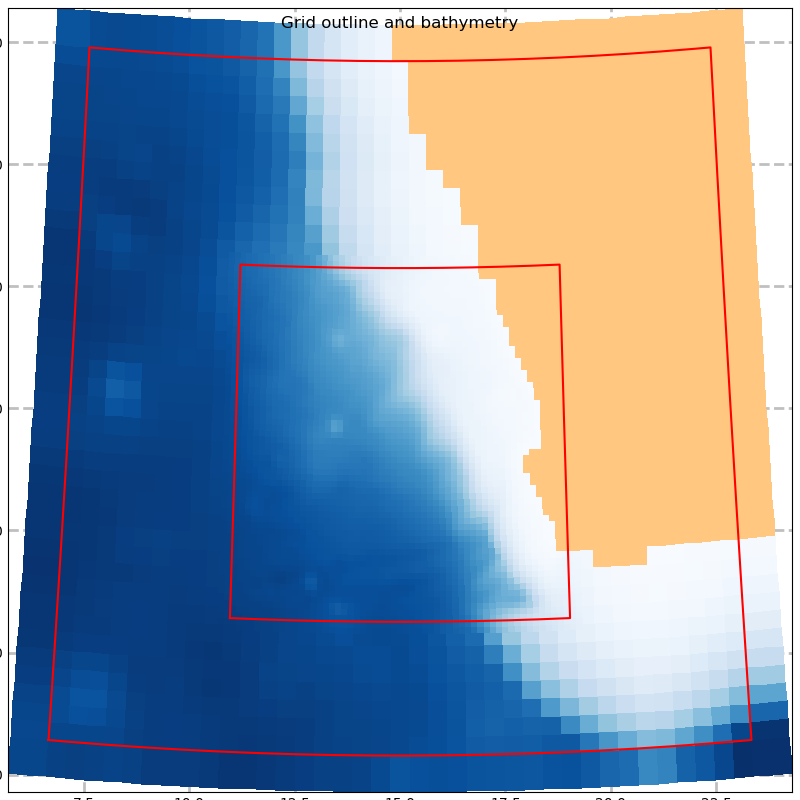

In [23]:
plt.style.use('_mpl-gallery')
figure2, ax2 = plt.subplots(figsize=(8, 8))
figure2.suptitle('Grid outline and bathymetry')
ax2 = plot_outline_ax(prt, ax2)
ax2, cb2 = plot_topo_bis(prt, figure2, ax2)
ax2 = plot_outline_ax(chd_grid, ax2)
ax2, cb2= plot_topo_bis(chd_grid, figure2, ax2)
#The colorbar is set as the one of the parent grid plot min/max
cb2.mappable.set_clim(vmin=prt.h.min(), vmax=prt.h.max())

### 💾 Save grid as necdf
This code creates a Netcdf file containing all grid data (geographic, topo-bathymetric, mask) in the format defined by the classes generated earlier in this notebook. Then it saves it in the ouput repertory.

In [20]:
prt_grd=['AGRIF',saved_config['parent_grid'],inputs.coef,inputs.imin,inputs.imax,inputs.jmin,inputs.jmax]
CROCO.create_grid_nc(None,saved_config['output_file'],inputs,chd_grid, prt_grd)

PermissionError: [Errno 13] Permission denied: '../../CROCO_FILES/croco_chd_grd.nc'